In [7]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline
from seaborn import displot, histplot, relplot, boxplot
plt.style.use(['nature'])
from tqdm import tqdm
from shapely.geometry import LineString
from conflict import ConflictLyft
from scipy import stats
import statsmodels.api as sm 

In [8]:
# first junction
with open('./lyft_avhv_conflict_j1.pkl', 'rb') as file:
    lyft_avhv_conflict_list1 = pickle.load(file)

with open('./lyft_hvhv_conflict_j1.pkl', 'rb') as file:
    lyft_hvhv_conflict_list1 = pickle.load(file)

lyft_conflict_list1 = lyft_avhv_conflict_list1 + lyft_hvhv_conflict_list1

# second junction
with open('./lyft_avhv_conflict_j2.pkl', 'rb') as file:
    lyft_avhv_conflict_list2 = pickle.load(file)

with open('./lyft_hvhv_conflict_j2.pkl', 'rb') as file:
    lyft_hvhv_conflict_list2 = pickle.load(file)

lyft_conflict_list2 = lyft_avhv_conflict_list2 + lyft_hvhv_conflict_list2

# report sample size
len(lyft_conflict_list1), len(lyft_conflict_list2)

(859, 886)

In [9]:
# convert the type to latest conflict object
conflict_list1 = list()
for c_index, c in enumerate(lyft_conflict_list1):
    # print(c_index)
    conflict_list1.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
        junction_id=1,
    ))
assert len(conflict_list1) == len(lyft_conflict_list1)

conflict_list2 = list()
for c_index, c in enumerate(lyft_conflict_list2):
    # print(c_index)
    conflict_list2.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
        junction_id=2,
    ))
assert len(conflict_list2) == len(lyft_conflict_list2)

conflict_list = conflict_list1 + conflict_list2

len(conflict_list1), len(conflict_list2)

(859, 886)

In [10]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
- maxREQDEC
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "maxREQDEC"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for index, conflict in tqdm(enumerate(conflict_list)):
    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    conflict_rows_in_df.append([
        conflict_type,
        leader_type+"-"+follower_type,
        conflict.PET,
        conflict.max_req_deceleration,
    ])
conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info()

1745it [00:00, 111213.33it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1745 entries, 0 to 1744
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  1745 non-null   object 
 1   Vehicle order  1745 non-null   object 
 2   PET            1745 non-null   float64
 3   maxREQDEC      1463 non-null   float64
dtypes: float64(2), object(2)
memory usage: 68.2+ KB


In [11]:
# Post-process: remove maxREQDEC greater than 10s
maxREQDEC_THRESHOLD = 3
conflict_df = conflict_df[conflict_df["maxREQDEC"] <= maxREQDEC_THRESHOLD]

# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1444 entries, 0 to 1744
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  1444 non-null   object 
 1   Vehicle order  1444 non-null   object 
 2   PET            1444 non-null   float64
 3   maxREQDEC      1444 non-null   float64
dtypes: float64(2), object(2)
memory usage: 56.4+ KB


In [12]:
conflict_df.to_csv("./outputs/trb/lyft_mrd.csv", index=False)

In [13]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['maxREQDEC'].mean()

Conflict type  Vehicle order
Cross          AV-HV            0.875449
               HV-AV            0.657767
               HV-HV            0.607787
Merge          AV-HV            0.849572
               HV-AV            0.539334
               HV-HV            0.588414
Name: maxREQDEC, dtype: float64

In [14]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['maxREQDEC'].std()

Conflict type  Vehicle order
Cross          AV-HV            0.562512
               HV-AV            0.249066
               HV-HV            0.524341
Merge          AV-HV            0.387019
               HV-AV            0.225277
               HV-HV            0.448165
Name: maxREQDEC, dtype: float64

In [15]:
HVHV = conflict_df[conflict_df["Vehicle order"] == "HV-HV"]
AVHV = conflict_df[conflict_df["Vehicle order"] == "AV-HV"]
HVAV = conflict_df[conflict_df["Vehicle order"] == "HV-AV"]

cross_df = conflict_df[conflict_df["Conflict type"] == "Cross"]
merge_df = conflict_df[conflict_df["Conflict type"] == "Merge"]

HVHV_cross = cross_df[cross_df["Vehicle order"] == "HV-HV"]
AVHV_cross = cross_df[cross_df["Vehicle order"] == "AV-HV"]
HVAV_cross = cross_df[cross_df["Vehicle order"] == "HV-AV"]

HVHV_merge = merge_df[merge_df["Vehicle order"] == "HV-HV"]
AVHV_merge = merge_df[merge_df["Vehicle order"] == "AV-HV"]
HVAV_merge = merge_df[merge_df["Vehicle order"] == "HV-AV"]

## Stats Test

### Normality Test

In [22]:
# HVHV::Cross
stats.shapiro(HVHV_cross.maxREQDEC).pvalue # 2.7307268605218e-15

# AVHV::Cross
stats.shapiro(AVHV_cross.maxREQDEC).pvalue # 0.01003706268966198

# HVAV::Cross
stats.shapiro(HVAV_cross.maxREQDEC).pvalue # 2.0142603140982374e-09

# HVHV::Merge
stats.shapiro(HVHV_merge.maxREQDEC).pvalue # 7.960624010262096e-20

# AVHV::Merge
stats.shapiro(AVHV_merge.maxREQDEC).pvalue # 0.2329382449388504

# HVAV::Merge
stats.shapiro(HVAV_merge.maxREQDEC).pvalue # 5.13558293113725e-12

5.13558293113725e-12

### Mann-Whitney U Test

In [18]:
# HVHV::HVAV | Cross
stats.mannwhitneyu(x=HVHV_cross.maxREQDEC, y=HVAV_cross.maxREQDEC, alternative="two-sided").pvalue # 0.003201624314039191

# HVHV::AVHV | Cross
stats.mannwhitneyu(x=HVHV_cross.maxREQDEC, y=AVHV_cross.maxREQDEC, alternative="two-sided").pvalue # 0.0008079146367372274

# HVAV::AVHV | Cross
stats.mannwhitneyu(x=HVAV_cross.maxREQDEC, y=AVHV_cross.maxREQDEC, alternative="two-sided").pvalue # 0.0007147080884238544

# HVHV::HVAV | Merge
stats.mannwhitneyu(HVHV_merge.maxREQDEC, HVAV_merge.maxREQDEC, alternative="two-sided").pvalue # 0.7526399149083962

# HVHV::AVHV | Merge
stats.mannwhitneyu(HVHV_merge.maxREQDEC, AVHV_merge.maxREQDEC, alternative="two-sided").pvalue # 3.6724763949104476e-13

# HVAV::AVHV | Merge
stats.mannwhitneyu(x=HVAV_merge.maxREQDEC, y=AVHV_merge.maxREQDEC, alternative="two-sided").pvalue # 7.940332091555702e-14

7.940332091555702e-14

### T-test

In [21]:
# HVHV::HVAV | Cross !!
stats.ttest_ind(HVHV_cross.maxREQDEC, HVAV_cross.maxREQDEC).pvalue # 0.3757728595618033

# HVHV::AVHV | Cross
stats.ttest_ind(HVHV_cross.maxREQDEC, AVHV_cross.maxREQDEC).pvalue # 0.00029747357786155985

# HVAV::AVHV | Cross
stats.ttest_ind(HVAV_cross.maxREQDEC, AVHV_cross.maxREQDEC).pvalue # 0.0013298178381811628

# HVHV::HVAV | Merge
stats.ttest_ind(HVHV_merge.maxREQDEC, HVAV_merge.maxREQDEC).pvalue # 0.14826428647623469

# HVHV::AVHV | Merge
stats.ttest_ind(HVHV_merge.maxREQDEC, AVHV_merge.maxREQDEC).pvalue # 2.1216350509041634e-10

# HVAV::AVHV | Merge
stats.ttest_ind(HVAV_merge.maxREQDEC, AVHV_merge.maxREQDEC).pvalue # 6.405479734908932e-18

6.405479734908932e-18

### ANOVA

In [10]:
# Merge
stats.f_oneway(HVHV_merge.maxREQDEC, HVAV_merge.maxREQDEC, AVHV_merge.maxREQDEC).pvalue # 8.38626989011627e-13

# Cross
stats.f_oneway(HVHV_cross.maxREQDEC, HVAV_cross.maxREQDEC, AVHV_cross.maxREQDEC).pvalue # 0.0004586689202786895

0.0004586689202786895

## Boxplots

In [10]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

Lyft

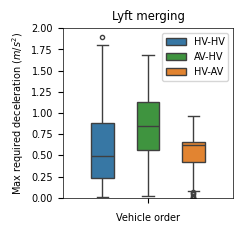

In [11]:
HVHV_COLOR = '#257ab6'
HVAV_COLOR = '#31a231'
AVHV_COLOR = '#ff8214'

FIGURE_WIDTH, FIGURE_HEIGHT = 2.2, 2.2
conflictType = "Merge"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

g = boxplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    y="maxREQDEC",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    gap=.5,
    legend=True,
)

g.set_xlabel("Vehicle order")
g.set_ylabel("Max required deceleration ($m/s^2$)")

handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles[0:], labels=labels[0:])
plt.ylim([0, 2])

plt.title(f"Lyft merging")
plt.savefig(f"./outputs/trb/mrd_lyft_merge.png", dpi=300, bbox_inches="tight")
plt.show()

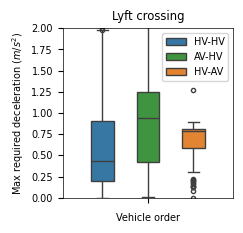

In [12]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

HVHV_COLOR = '#257ab6'
HVAV_COLOR = '#31a231'
AVHV_COLOR = '#ff8214'

FIGURE_WIDTH, FIGURE_HEIGHT = 2.2, 2.2
conflictType = "Cross"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

g = boxplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    y="maxREQDEC",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    gap=.5,
    legend=True,
)

g.set_xlabel("Vehicle order")
g.set_ylabel("Max required deceleration ($m/s^2$)")
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles[0:], labels=labels[0:])
plt.ylim([0, 2])

plt.title(f"Lyft crossing")
plt.savefig(f"./outputs/trb/mrd_lyft_cross.png", dpi=300, bbox_inches="tight")
plt.show()

Waymo 

In [44]:
# palette = {
#     "HV-HV" : '#257ab6', 
#     "AV-HV" : '#31a231',
#     "HV-AV" : '#ff8214',
# }

# HVHV_COLOR = '#257ab6'
# HVAV_COLOR = '#31a231'
# AVHV_COLOR = '#ff8214'

# FIGURE_WIDTH, FIGURE_HEIGHT = 2.2, 2.2
# conflictType = "Cross"
# plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

# df = pd.read_csv("./outputs/plots/waymo_max_req_dec_cross.csv")
# g = boxplot(
#     data=df,
#     y="maxREQDEC",
#     hue="Vehicle order",
#     hue_order=["HV-HV", "AV-HV", "HV-AV"],
#     palette=palette,
#     gap=.5,
#     legend=True,
# )

# g.set_xlabel("Vehicle order")
# g.set_ylabel("Max required deceleration ($m/s^2$)")
# handles, labels = g.get_legend_handles_labels()
# g.legend(handles=handles[0:], labels=labels[0:])
# plt.ylim([0, 2])

# plt.title(f"Waymo crossing")
# plt.savefig(f"./outputs/trb/mrd_waymo_cross.png", dpi=300, bbox_inches="tight")
# plt.show()

In [43]:
# palette = {
#     "HV-HV" : '#257ab6', 
#     "AV-HV" : '#31a231',
#     "HV-AV" : '#ff8214',
# }

# HVHV_COLOR = '#257ab6'
# HVAV_COLOR = '#31a231'
# AVHV_COLOR = '#ff8214'

# FIGURE_WIDTH, FIGURE_HEIGHT = 2.2, 2.2
# conflictType = "Merge"
# plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

# df = pd.read_csv("./outputs/plots/waymo_max_req_dec_merge.csv")
# g = boxplot(
#     data=df,
#     y="maxREQDEC",
#     hue="Vehicle order",
#     hue_order=["HV-HV", "AV-HV", "HV-AV"],
#     palette=palette,
#     gap=.5,
#     legend=True,
# )

# g.set_xlabel("Vehicle order")
# g.set_ylabel("Max required deceleration ($m/s^2$)")
# handles, labels = g.get_legend_handles_labels()
# g.legend(handles=handles[0:], labels=labels[0:])
# plt.ylim([0, 2])
# plt.title(f"Waymo merging")
# plt.savefig(f"./outputs/plots/mrd_waymo_merge.png", dpi=300, bbox_inches="tight")
# plt.show()